# Dreambooth: Few Shot Fine-Tuning for Personalized Stable Diffusion
---

In this notebook, we'll leverage Ray's capabilities to efficiently distribute the fine-tuning and inference processes for a text-to-image generation model. This strategy draws inspiration from the pioneering work of [Dreambooth](https://arxiv.org/abs/2208.12242), which introduced a methodology to tailor diffusion models according to individual subjects.

By the conclusion of this guide, you'll not only possess a finely tuned model with the ability to portray a distinctive dog within a diverse array of scenarios, but you'll also cultivate a more profound comprehension of harnessing Ray for scaling up training and inference tasks across numerous computational nodes.

**Table of Contents**

1. [Set-Up](#1-set-up)
    * Define the file structure
    * Download the base model
    * Download the few-shot input images
    * Display example image
2. [Augmenting the Training Dataset](#2-augmenting-the-training-dataset)
    * Define class for generating images
    * Generate class images with Ray Data
    * Display example image
3. [Creating the Training Dataset](#3-create-the-training-dataset)
    * Write prompts
    * Build training dataset
4. [Run Fine-Tuning](#4-run-fine-tuning)
    * Import packages
    * Define training logic
    * Launch fine-tuning
5. [Test the Fine-Tuned Model](#5-test-the-fine-tuned-model)
    * Use Ray Data to generate images
    * Display example image


## 1. Set-Up

In [1]:
import os
import shutil


### Define the file structure

In [2]:
# This is a NFS mounted on every node of the cluster, so it's accessible to all worker nodes.
storage_dir = "/mnt/cluster_storage"

# The name of the model to be pulled from Hugging Face.
base_model_name = "CompVis/stable-diffusion-v1-4"
# The specific commit hash to download from.
base_model_hash = "b95be7d6f134c3a9e62ee616f310733567f069ce"

# Construct the directory path for the base model and its snapshots.
base_model_dir = f"{storage_dir}/base-model"
base_model_path = f"{base_model_dir}/models--{base_model_name.replace('/', '--')}/snapshots/{base_model_hash}"

# Create a directory path for the fine-tuned model.
fine_tuned_model_dir = f"{storage_dir}/fine-tuned-model"


In [3]:
# Directory for ~5 images of the original subject matter.
instance_images_dir = f"{storage_dir}/instance-images"

# Directory for ~200 images of the same class as the subject for regularization.
class_images_dir = f"{storage_dir}/class-images"

# Directory for newly generated images from the fine-tuned model.
output_images_dir = f"{storage_dir}/output-images"


Below, we'll create the image directories. The model directories will automatically be handled by Hugging Face when you specify a `cache_dir`.

In [4]:
image_directories = [class_images_dir, instance_images_dir, output_images_dir]

for directory in image_directories:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)


### Download the base model

In [5]:
from huggingface_hub import snapshot_download


In [6]:
snapshot_download(
    repo_id=base_model_name, revision=base_model_hash, cache_dir=base_model_dir
)

Fetching 31 files:   0%|          | 0/31 [00:00<?, ?it/s]

'/mnt/cluster_storage/base-model/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce'

### Download the few-shot input images

> **Exercise**
> 
> We're downloading five photos of a dog to fine-tune the Stable Diffusion model, but these images could be of anything! Instead of using these stock images, replace them with your favorite object or person.
>
> You should only need 3-5 instances of the subject matter to achieve decent results.

In [7]:
# Download five images of a unique subject matter (dog).
snapshot_download(
    "diffusers/dog-example",
    local_dir=instance_images_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/efs/workspaces/expwrk_bbp9lfghp7ijx6w8zj4uivm1w7/cluster_storage/instance-images'

### Display example image

In [8]:
from IPython.display import display, Image

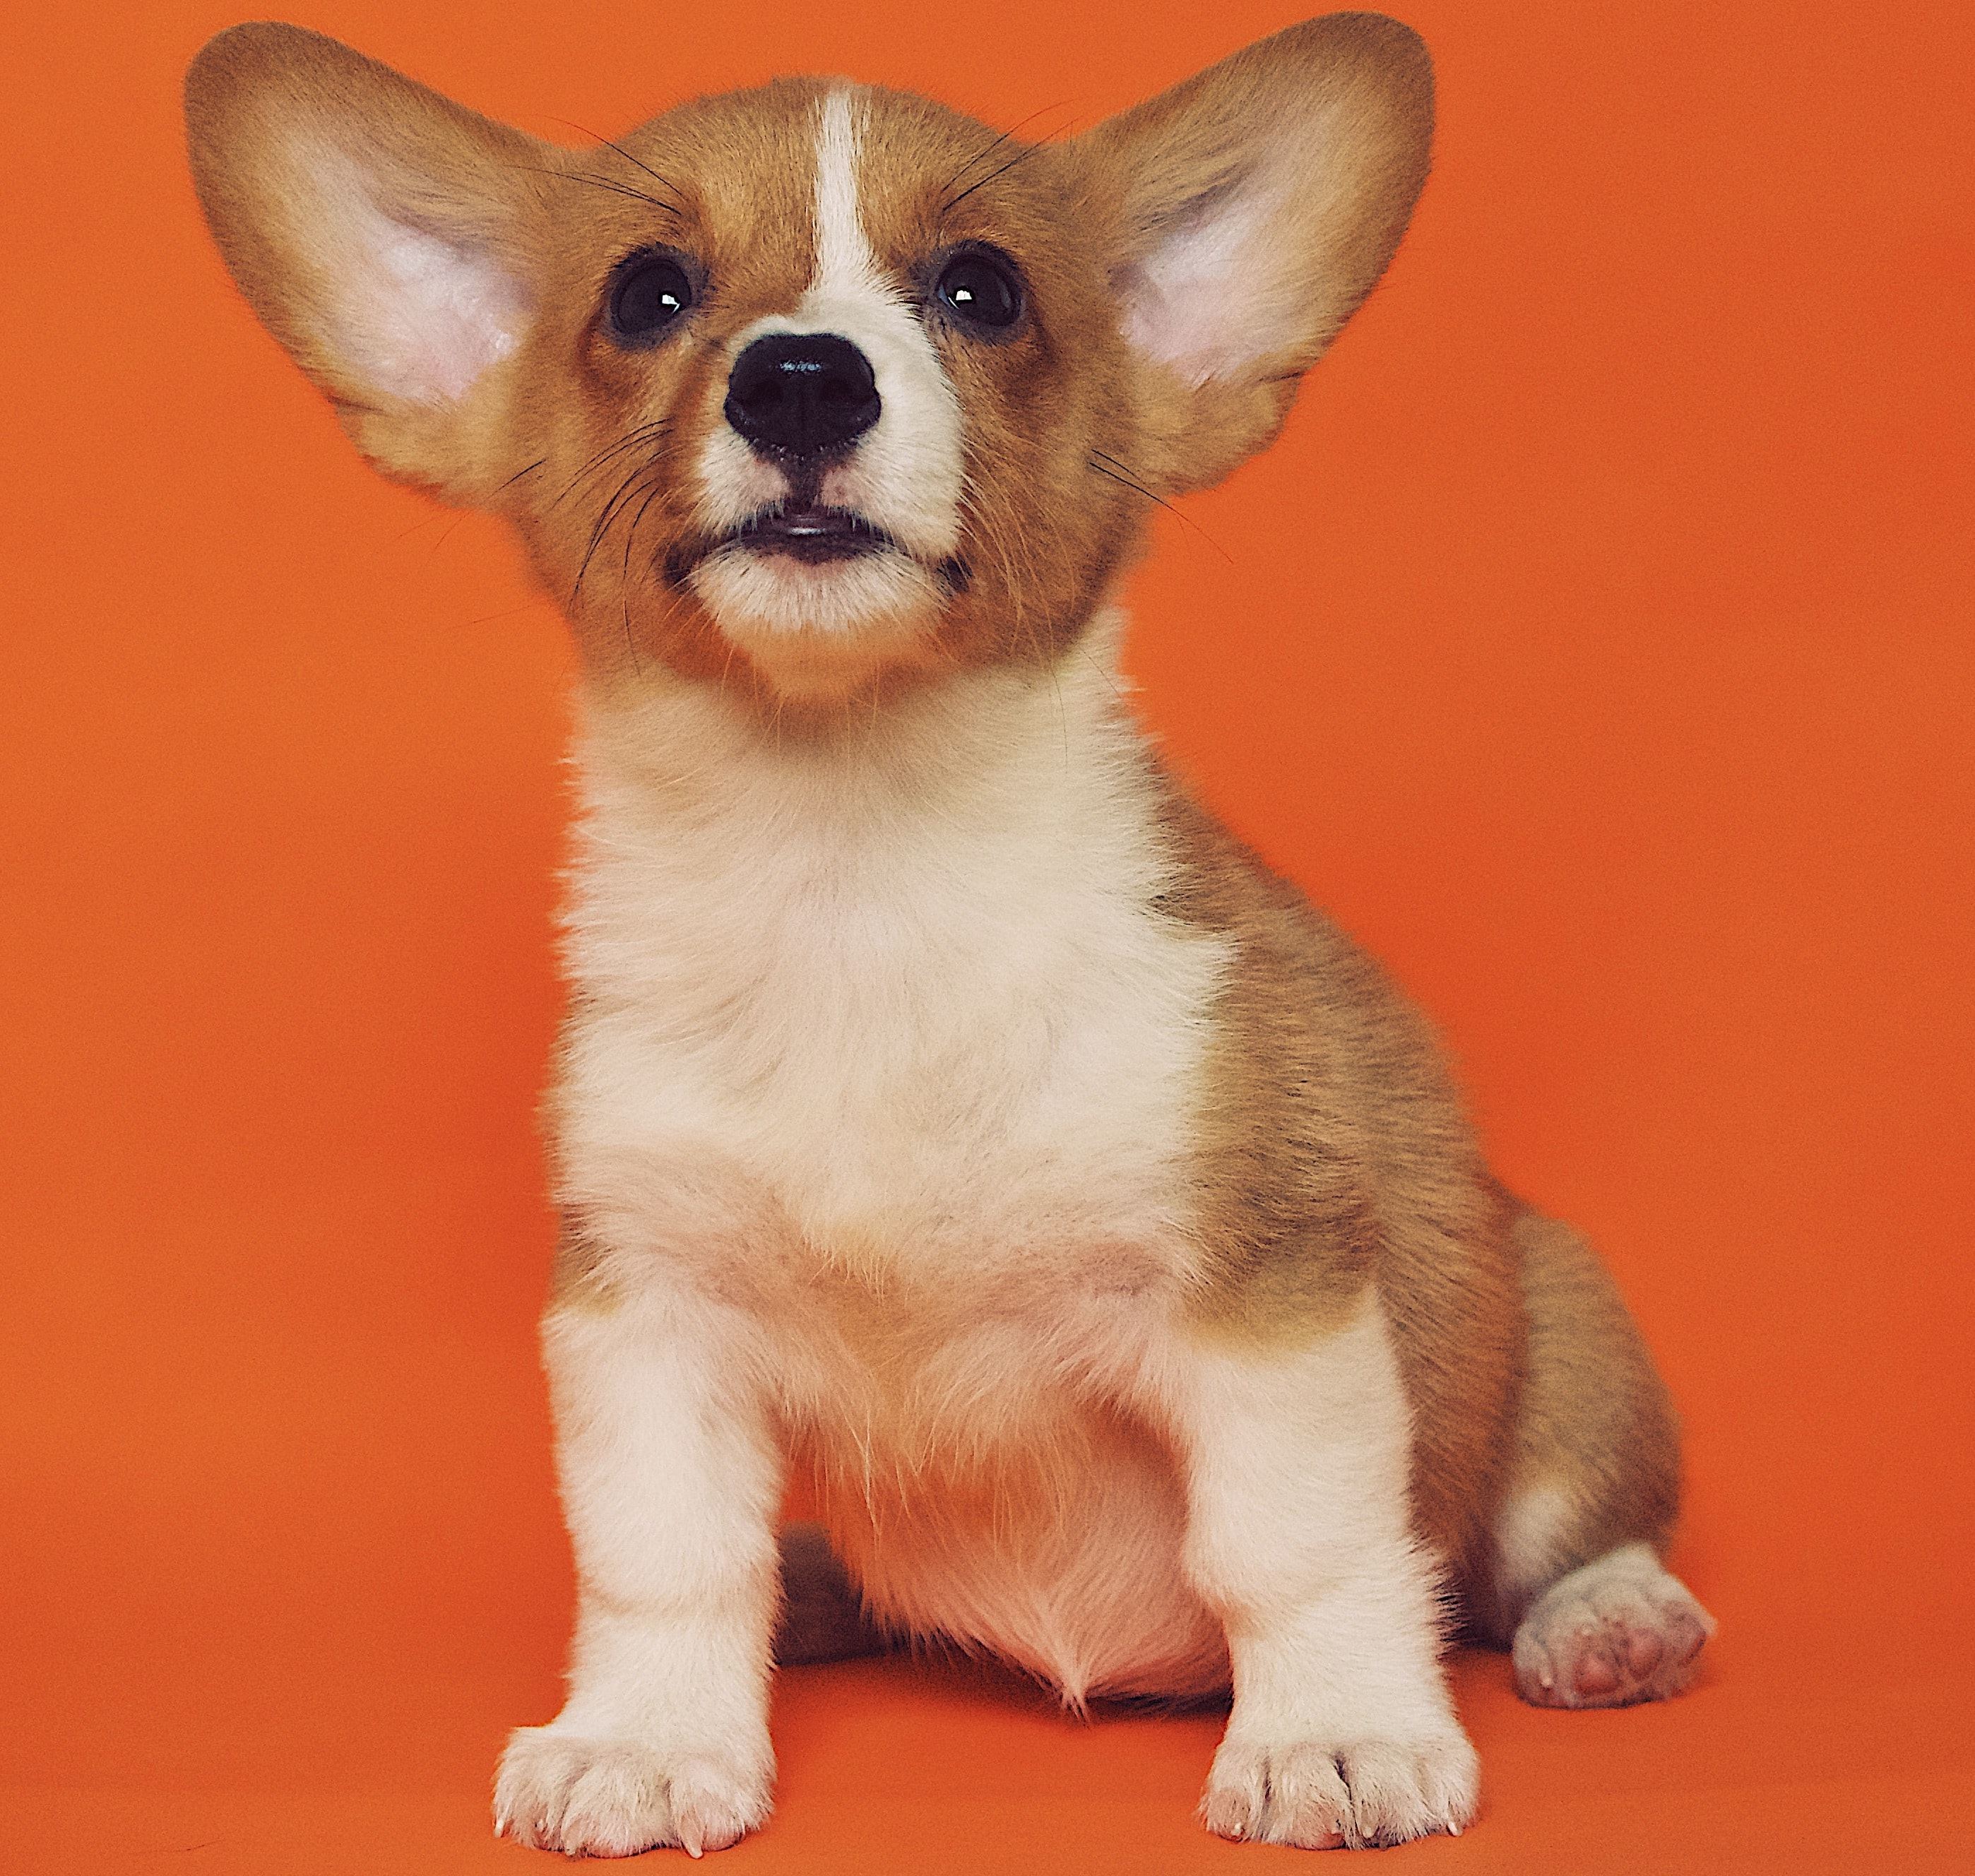

In [9]:
example_image = os.listdir(instance_images_dir)[0]
image_path = os.path.join(instance_images_dir, example_image)

display(Image(filename=image_path))

## 2. Augmenting the Training Dataset

**Prior Preservation Loss in Text-to-Image Generation**

In text-to-image synthesis, the "prior preservation loss" is a technique used in personalized text-to-image diffusion models that addresses the challenge of generating diverse images of a specific subject while maintaining the diversity of images of the same class.

In other words, we want the model to be able to generate varied images of *our* dog but not make *all* generated dogs look like our dog. Generic dogs are our *prior*, and we're trying to *preserve* that through the fine-tuning process.

**Two-Part Training Data** 
1. **Unique Identifier and Class:** Input images are paired with prompts containing unique identifiers and class names (e.g., "A [unqtkn] dog").
2. **Autogenous Class-Specific Loss:** To prevent overfitting to specific instances, we let the base model itself generate class images (e.g. "A dog") to feed into the training dataset.

Check out the [original paper](https://arxiv.org/pdf/2208.12242.pdf) for more details.

In [10]:
import hashlib
import ray
import torch
import numpy as np

from diffusers import DiffusionPipeline
from os import path


### Define class for generating images

`StableDiffusionCallable` generates images using a pre-trained generative model from a specified directory. It initializes the model, generates a specified number of images per input prompt, and returns the generated images as a list of dictionaries.

In [11]:
class StableDiffusionCallable:
    def __init__(self, model_dir, num_samples_per_prompt):
        print(f"Loading model from {model_dir}")
        self.pipeline = DiffusionPipeline.from_pretrained(
            model_dir, torch_dtype=torch.float16
        )
        self.pipeline.set_progress_bar_config(disable=True)
        self._num_samples = num_samples_per_prompt
        self.pipeline.to("cuda")  # Ray will let us guarantee a GPU is available

    def __call__(self, prompt):
        images = []
        for i in range(self._num_samples):
            image = self.pipeline(prompt["item"]).images[0]
            images.append(
                np.array(image)
            )  # This needs to be in the right format for writing.
            print(f"Generated image {i} of {self._num_samples}")
        return [{"image": image} for image in images]


### Generate class images with Ray Data

We'll use the base Stable Diffusion model to generate our class images, and use Ray Data to scale this across our available GPUs (2 for today, but can be more and can be a mix of CPUs and GPUs). Since we pass `n` prompts in and get `m` images out and want a collection of all the samples at the end, we'll use `flat_map`.

Interested in learning more about Ray Data's transformation semantics? Click [here](https://docs.ray.io/en/latest/data/transforming-data.html).

In [12]:
class_name = "dog"  # General category of the subject matter.
prompts_list = [f"photo of a {class_name}"]

num_samples_per_prompt = 200  # Number recommended in original paper.

In [13]:
# Create a Ray Dataset.
prompt_ds = ray.data.from_items(prompts_list)

# Use `flat_map` to turn `n` prompts into `m` images.
images_ds = prompt_ds.flat_map(
    StableDiffusionCallable,
    compute=ray.data.ActorPoolStrategy(
        size=2
    ),  # fixed pool of 2 workers since we have 2 GPUs; no autoscaling.
    fn_constructor_args=(base_model_path, num_samples_per_prompt),
    num_gpus=1,  # This is per worker
)

2023-08-22 12:17:54,655	INFO worker.py:1459 -- Connecting to existing Ray cluster at address: 10.0.26.242:6379...
2023-08-22 12:17:54,661	INFO worker.py:1640 -- Connected to Ray cluster. View the dashboard at https://session-ivr1fh8mjkvmn8vcr5un48u9jc.i.anyscaleuserdata.com 
2023-08-22 12:17:54,667	INFO packaging.py:346 -- Pushing file package 'gcs://_ray_pkg_f2d456043db7dee6c9bc2cb77666f427.zip' (1.88MiB) to Ray cluster...
2023-08-22 12:17:54,670	INFO packaging.py:359 -- Successfully pushed file package 'gcs://_ray_pkg_f2d456043db7dee6c9bc2cb77666f427.zip'.


Ray Datasets are lazy by default, so any transformations are only triggered when the dataset is consumed, like with `write_images()`.

In [14]:
images_ds.write_images(class_images_dir, column="image")


2023-08-22 12:17:54,878	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[FlatMap(StableDiffusionCallable)] -> TaskPoolMapOperator[Write]
2023-08-22 12:17:54,878	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 12:17:54,879	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-22 12:17:54,900	INFO actor_pool_map_operator.py:106 -- FlatMap(StableDiffusionCallable): Waiting for 2 pool actors to start...


(_MapWorker pid=63631, ip=10.0.59.136) Loading model from /mnt/cluster_storage/base-model/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce


(_MapWorker pid=133655) `text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


(autoscaler +7s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 0 of 200
(_MapWorker pid=133655) Loading model from /mnt/cluster_storage/base-model/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce
(autoscaler +16s) [activity] Cluster is active (source: ray).
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 1 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 2 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 3 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 4 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 5 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 6 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 7 of 200
(MapWorker(FlatMap(StableDiffusionCallable)) pid=133655) Generated image 8 of 200
(MapWorker(FlatMap(StableDiffusionC

2023-08-22 12:28:29,766	WARNING actor_pool_map_operator.py:275 -- To ensure full parallelization across an actor pool of size 2, the Dataset should consist of at least 2 distinct blocks. Consider increasing the parallelism when creating the Dataset.


### Display example image

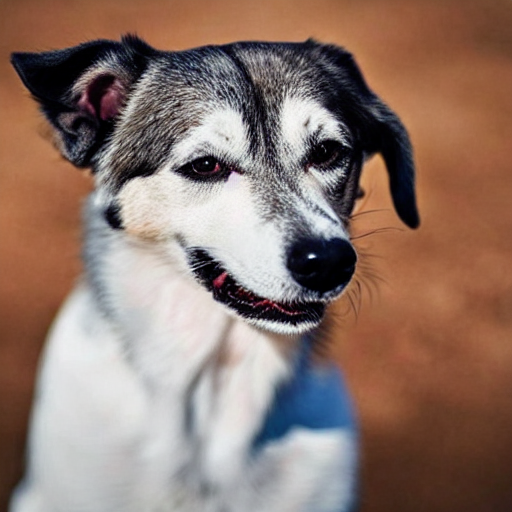

In [15]:
example_class_image = os.listdir(class_images_dir)[0]
class_image_path = os.path.join(class_images_dir, example_class_image)

display(Image(filename=class_image_path))

## 3. Create the Training Dataset

<span style='color:mediumslateblue;font-size:18pt;'>[insert diagram duplicating instance images]</span>

### Write prompts

In [16]:
unique_token = "unqtkn"  # Unique identifier for the individual subject matter.
instance_prompt = f"photo of {unique_token} {class_name}"
class_prompt = f"photo of a {class_name}"

### Build training dataset

In [25]:
from utils import get_train_dataset, collate

In [26]:
train_dataset = get_train_dataset(
    base_model_path,
    instance_images_dir,
    class_images_dir,
    instance_prompt,
    class_prompt,
)

2023-08-22 12:41:15,658	INFO read_api.py:403 -- To satisfy the requested parallelism of 64, each read task output is split into 13 smaller blocks.
2023-08-22 12:41:16,131	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)]
2023-08-22 12:41:16,131	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 12:41:16,132	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/832 [00:00<?, ?it/s]

2023-08-22 12:41:27,464	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)]
2023-08-22 12:41:27,465	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 12:41:27,465	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/88 [00:00<?, ?it/s]

2023-08-22 12:41:29,391	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> LimitOperator[limit=1]
2023-08-22 12:41:29,392	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 12:41:29,393	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ra

Training dataset schema after pre-processing:


- Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

- Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(autoscaler +23m42s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}
Column               Type
------               ----
instance_image       <class 'object'>
instance_prompt_ids  <class 'object'>
class_image          <class 'object'>
class_prompt_ids     <class 'object'>


## 4. Run Fine-Tuning

First, we'll set up the training logic in `train_fn`for the fine-tuning loop. This involves the following:

1. **Loading Pre-trained Models**: Pre-trained components, including a text encoder, noise scheduler, VAE, and UNet model, are loaded.

2. **Training Preparation**: Models are configured for training, and the VAE is moved to the appropriate device.

3. **Optimizer Configuration**: An AdamW optimizer is set up to optimize trainable parameters.

4. **Data Loading**: Training data is loaded.

5. **Training Loop**: For a set number of epochs:
   - Data is processed in batches.
   - Images are encoded using the VAE and scaled.
   - Noise is added using a diffusion process.
   - Text embeddings are generated.
   - The UNet predicts noise residuals.
   - Loss is computed and gradients are backpropagated.
   - Model parameters are updated with gradient clipping.
   - Training results are reported.

6. **Pipeline Creation and Saving**: After training, a pipeline is created using trained modules. The pipeline is saved if the process is the primary one.

After this, we can run distributed fine-tuning with Ray Train by wrapping the training and scaling logic in Ray's `TorchTrainer`.

### Imports for training

In [27]:
import itertools
import pandas as pd

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.utils.import_utils import is_xformers_available
from ray import train
from ray.data import read_images
from ray.data.preprocessors import TorchVisionPreprocessor
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer

from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F

from torchvision import transforms

from transformers import AutoTokenizer
from transformers import CLIPTextModel

from typing import Dict
from utils import prior_preserving_loss, get_target, load_models, unet_attn_processors_state_dict


### Define training logic

There's a lot going on in the following function (and even more functions tucked away in `utils.py`). The important thing to focus on, however, is that porting this training logic to Ray involves minimal code changes.

Your training logic will be different according to your specific use case, and running this in a distributed setting only involves wrapping this function with a Ray `Trainer` and defining some scaling logic.

In [28]:
def train_fn(config):

    # Load pre-trained models.
    (
        text_encoder, # Pre-trained text encoder
        noise_scheduler, # Noise scheduler for diffusion process
        vae,  # Variational Autoencoder
        unet,  # UNet-based generative model
        unet_trainable_parameters,  # Trainable parameters of the UNet
        text_trainable_parameters,  # Trainable parameters of the text encoder
    ) = load_models(config)  # Load pre-trained models using provided configuration

    # Set models in training mode.
    text_encoder.train()
    unet.train()

    # Prepare models for training.
    text_encoder = train.torch.prepare_model(text_encoder)
    unet = train.torch.prepare_model(unet)
    # Manually move VAE to device as `prepare_model` can't be used on
    # non-training models.
    vae = vae.to(train.torch.get_device())

    # Use the AdamW optimizer to work with bfloat16 weights.
    optimizer = torch.optim.AdamW(
        itertools.chain(unet_trainable_parameters, text_trainable_parameters),
        lr=config["lr"],
    )

    # Load the training dataset.
    train_dataset = train.get_dataset_shard("train")

    ########################
    # Start: Training loop #
    ########################
    num_train_epochs = config["num_epochs"]

    print(f"Running {num_train_epochs} epochs.")

    global_step = 0
    for _ in range(num_train_epochs):
        if global_step >= config["max_train_steps"]:
            print(f"Stopping training after reaching {global_step} steps...")
            break
        
        # Iterate through batches in the training dataset.
        for _, batch in enumerate(
            train_dataset.iter_torch_batches(
                batch_size=config["train_batch_size"],
                device=train.torch.get_device(),
            )
        ):
            # Collate the batch and convert to bfloat16 format.
            batch = collate(batch, torch.bfloat16)

            # Zero the gradients of the optimizer.
            optimizer.zero_grad()

            # Encode images into latent space using the VAE and scale by a constant.
            latents = vae.encode(batch["images"]).latent_dist.sample() * 0.18215

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bsz,),
                device=latents.device,
            )
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning from the text encoder.
            encoder_hidden_states = text_encoder(batch["prompt_ids"])[0]

            # Predict the noise residual using the UNet model.
            model_pred = unet(
                noisy_latents.to(train.torch.get_device()),
                timesteps.to(train.torch.get_device()),
                encoder_hidden_states.to(train.torch.get_device()),
            ).sample

            # Calculate target values for loss computation.
            target = get_target(noise_scheduler, noise, latents, timesteps)

            # Calculate the loss that preservers the model's prior.
            loss = prior_preserving_loss(
                model_pred, target, config["prior_loss_weight"]
            )

            # Backpropogate the loss.
            loss.backward()

            # Gradient clipping before optimizer stepping to prevent exploding gradients.
            clip_grad_norm_(
                itertools.chain(unet_trainable_parameters, text_trainable_parameters),
                config["max_grad_norm"],
            )

            # Update model parameters using the optimizer.
            optimizer.step()  # Step all optimizers.

            # Increment global step counter and report training results.
            global_step += 1
            results = {
                "step": global_step,
                "loss": loss.detach().item(),
            }
            train.report(results)

            # Check if the maximum training steps have been reached.
            if global_step >= config["max_train_steps"]:
                break
    ######################
    # End: Training loop #
    ######################

    # Create pipeline using the trained modules and save it.
    if train.get_context().get_world_rank() == 0:
        pipeline = DiffusionPipeline.from_pretrained(
            config["model_dir"],
            text_encoder=text_encoder.module,
            unet=unet.module,
        )
        pipeline.save_pretrained(config["output_dir"])


### Launch fine-tuning

In [29]:
# Number of GPUs available
num_workers = 2

# Set hyperparameters per https://huggingface.co/blog/dreambooth
train_loop_config = {
    "model_dir": base_model_path,
    "output_dir": fine_tuned_model_dir,
    "instance_images_dir": instance_images_dir,
    "instance_prompt": instance_prompt,
    "class_images_dir": class_images_dir,
    "class_prompt": class_prompt,
    "train_batch_size": 2,
    "lr": 5e-6,
    "num_epochs": 10,
    "max_train_steps": 400,
    "prior_loss_weight": 1.0,
    "max_grad_norm": 1.0,
    "num_workers": num_workers,
}


In [30]:
# Use Ray Train's TorchTrainer to wrap training and scaling logic.
trainer = TorchTrainer(
    train_fn,
    train_loop_config=train_loop_config,
    scaling_config=ScalingConfig(
        use_gpu=True,
        num_workers=num_workers,
    ),
    datasets={
        "train": train_dataset,
    },
)

result = trainer.fit()

(TorchTrainer pid=152757) Starting distributed worker processes: ['152831 (10.0.26.242)', '73987 (10.0.59.136)']
(RayTrainWorker pid=152831) Setting up process group for: env:// [rank=0, world_size=2]
(SplitCoordinator pid=152896) Auto configuring locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b']
(RayTrainWorker pid=73987, ip=10.0.59.136) Moving model to device: cuda:0
(RayTrainWorker pid=73987, ip=10.0.59.136) Wrapping provided model in DistributedDataParallel.


(RayTrainWorker pid=73987, ip=10.0.59.136) Running 10 epochs.


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(RayTrainWorker pid=152831) Running 10 epochs.
(autoscaler +24m16s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}
(autoscaler +24m28s) [workspace snapshot] New snapshot created successfully (size: 2.50 MB).


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +25m36s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +26m52s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +28m5s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +29m21s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}
(autoscaler +29m28s) [workspace snapshot] New snapshot created successfully (size: 2.51 MB).


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +30m37s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +31m52s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}


(SplitCoordinator pid=152896) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->SplitBlocks(13)] -> TaskPoolMapOperator[MapBatches(<lambda>)->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition], InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(TorchVisionPreprocessor._transform_numpy)->MapBatches(<lambda>)->MapBatches(process_batch)] -> LimitOperator[limit=200] -> AllToAllOperator[Repartition] -> ZipOperator[Zip] -> AllToAllOperator[RandomShuffle] -> OutputSplitter[split(2, equal=True)]
(SplitCoordinator pid=152896) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=2000000000.0), locality_with_output=['cbd60f73847df74d7d1655e2177f501b24027b88aacb334dad3e7319', '179e5fc31dfbacb5d0caec26f3db89bcc11ec061465c02dafe1c328b'], preserve_order=True, actor_locality_enabled=True, verbose_

(pid=152896) - Repartition 1:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 2:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - Repartition 3:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Split Repartition 4:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) - RandomShuffle 5:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Map 6:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Shuffle Reduce 7:   0%|          | 0/200 [00:00<?, ?it/s]

(pid=152896) Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(autoscaler +33m2s) [autoscaler] Current infeasible cluster resource constraints: {"minBundles":[{"request":{"resourcesBundle":{"CPU":1}},"count":"33"}]}
(RayTrainWorker pid=73987, ip=10.0.59.136) Stopping training after reaching 400 steps...


(RayTrainWorker pid=152831) `text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
2023-08-22 12:52:17,187	INFO tune.py:1146 -- Total run time: 638.48 seconds (638.40 seconds for the tuning loop).


## 5. Test the Fine-Tuned Model

Now that we have our fine-tuned model, let's try to generate a few images of our unique subject matter.

> **Exercise**
>
> Modify the prompts list to generate the same subject matter with different contexts, properties, views, and/or accessories. See if you can build a list of prompts that qualitatively probe the performance of the fine-tuned model. Can you spot weaknesses in the training dataset methodology?
> 
> Check out the [Dreambooth paper](https://dreambooth.github.io/) for more ideas!

In [31]:
prompts_list = [f"photo of a {unique_token} {class_name}"] # Modify me with something exciting!
num_samples_per_prompt = 5


### Use Ray Data to generate images

In [32]:
prompt_ds = ray.data.from_items(prompts_list)

images_ds = prompt_ds.flat_map(
    StableDiffusionCallable,
    compute=ray.data.ActorPoolStrategy(
        size=2
    ),  # fixed pool of 2 workers since we have 2 GPUs; no autoscaling.
    fn_constructor_args=(fine_tuned_model_dir, num_samples_per_prompt),
    num_gpus=1,  # This is per worker
).write_images(output_images_dir, column="image")


2023-08-22 12:52:18,071	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[FlatMap(StableDiffusionCallable)] -> TaskPoolMapOperator[Write]
2023-08-22 12:52:18,072	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-08-22 12:52:18,072	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-08-22 12:52:18,094	INFO actor_pool_map_operator.py:106 -- FlatMap(StableDiffusionCallable): Waiting for 2 pool actors to start...


(autoscaler +34m28s) [workspace snapshot] New snapshot created successfully (size: 2.53 MB).
(_MapWorker pid=127910, ip=10.0.59.136) Loading model from /mnt/cluster_storage/fine-tuned-model


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapWorker(FlatMap(StableDiffusionCallable)) pid=202872) Generated image 0 of 5
(_MapWorker pid=202872) Loading model from /mnt/cluster_storage/fine-tuned-model
(MapWorker(FlatMap(StableDiffusionCallable)) pid=202872) Generated image 1 of 5
(MapWorker(FlatMap(StableDiffusionCallable)) pid=202872) Generated image 2 of 5
(MapWorker(FlatMap(StableDiffusionCallable)) pid=202872) Generated image 3 of 5
(MapWorker(FlatMap(StableDiffusionCallable)) pid=202872) Generated image 4 of 5


2023-08-22 12:53:15,350	WARNING actor_pool_map_operator.py:275 -- To ensure full parallelization across an actor pool of size 2, the Dataset should consist of at least 2 distinct blocks. Consider increasing the parallelism when creating the Dataset.


### Display example image

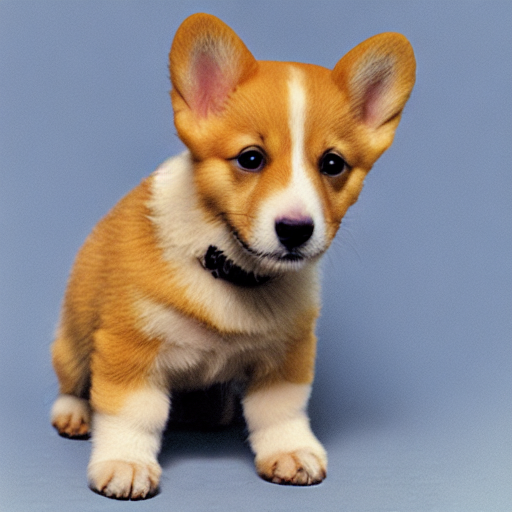

(autoscaler +39m28s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +44m28s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +49m28s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +54m28s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +59m28s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +1h4m29s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +1h9m34s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +1h14m34s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +1h19m34s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +1h24m34s) [workspace snapshot] New snapshot created successfully (size: 2.93 MB).
(autoscaler +1h29m34s) [workspace snapshot] New snapshot creat

In [33]:
example_image = os.listdir(output_images_dir)[0]
image_path = os.path.join(output_images_dir, example_image)

display(Image(filename=image_path))